<h1 align="center"> Image Captioning</h1>

In this notebook you will teach a network to do image captioning.
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

Cost of this notebook is **15 points**.

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [2]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

CPU times: user 1.01 s, sys: 1.2 s, total: 2.21 s
Wall time: 644 ms


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
for caption in captions:
    for sent in caption:
        for word in sent:
            word_counts[word] += 1

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(
            num_embeddings=n_tokens,
            embedding_dim=emb_size
        )
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=lstm_units,
            batch_first=True,
        )
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(in_features=lstm_units, out_features=n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out, (hidden, cell) = self.lstm(captions_emb, (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits        

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = CaptionNet(n_tokens)
network.to(device)

CaptionNet(
  (cnn_to_h0): Linear(in_features=2048, out_features=256, bias=True)
  (cnn_to_c0): Linear(in_features=2048, out_features=256, bias=True)
  (emb): Embedding(10403, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (logits): Linear(in_features=256, out_features=10403, bias=True)
)

In [12]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [13]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
#     logp_for_next = F.log_softmax(logits_for_next, dim=-1)
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
#     print(logits_for_next.view(-1).shape, captions_ix_next.view(-1).shape)

    criterion = nn.CrossEntropyLoss(ignore_index=pad_ix)
    loss = criterion(logits_for_next.view(-1, logits_for_next.shape[-1]),
                     captions_ix_next.view(-1))
    
    return loss

In [17]:
dummy_loss = compute_loss(network, dummy_img_vec.to(device), dummy_capt_ix.to(device))

# assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [18]:
opt = torch.optim.Adam(network.parameters())

# Training

* First implement the batch generator
* Than train the network as usual

In [19]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/var/folders/58/stmjh7594pz97tw2s0r0kfkw0000gn/T/ipykernel_90409/1291120523.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  captions = np.array(captions)


In [20]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [21]:
generate_batch(img_codes,captions,3)

(tensor([[0.3425, 0.1046, 0.2064,  ..., 0.0747, 0.3799, 0.4784],
         [0.0775, 0.2060, 0.1516,  ..., 0.4480, 0.5088, 0.3507],
         [0.1349, 0.1314, 1.0871,  ..., 0.2523, 0.4076, 0.1819]]),
 tensor([[   1,   24,  439,   14, 6674,   53,  182,   15,  210,  427,   17,   42,
           376,   12,    2],
         [   1,  247,  305, 2036,   58,   24,  452,    6,   45,  309,   12,    2,
             3,    3,    3],
         [   1,   24,  209,   81, 1156, 3612,  459,   24, 1413, 1019,    2,    3,
             3,    3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [22]:
batch_size = 50  # adjust me
n_epochs = 100  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [23]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        opt.zero_grad()
        loss_t.backward()
        opt.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.26it/s]



Epoch: 0, train loss: 6.06156777381897, val loss: 4.818483448028564


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.20it/s]



Epoch: 1, train loss: 4.719390344619751, val loss: 4.605717372894287


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.40it/s]



Epoch: 2, train loss: 4.459912214279175, val loss: 4.356012344360352


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 12.27it/s]



Epoch: 3, train loss: 4.2712109088897705, val loss: 4.218030166625977


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.09it/s]



Epoch: 4, train loss: 4.124055805206299, val loss: 4.121863174438476


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.33it/s]



Epoch: 5, train loss: 4.0131851053237915, val loss: 3.9140645027160645


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 12.15it/s]



Epoch: 6, train loss: 3.9181236362457277, val loss: 3.902762031555176


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.74it/s]



Epoch: 7, train loss: 3.832624006271362, val loss: 3.767789363861084


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 12.08it/s]



Epoch: 8, train loss: 3.7053576803207395, val loss: 3.732750988006592


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.68it/s]



Epoch: 9, train loss: 3.6704460048675536, val loss: 3.623302698135376


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.70it/s]



Epoch: 10, train loss: 3.5999292278289796, val loss: 3.6817583560943605


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.78it/s]



Epoch: 11, train loss: 3.510861568450928, val loss: 3.5324867248535154


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.56it/s]



Epoch: 12, train loss: 3.470687346458435, val loss: 3.5067959308624266


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 12.46it/s]



Epoch: 13, train loss: 3.3977677249908447, val loss: 3.376062297821045


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.56it/s]



Epoch: 14, train loss: 3.3726762771606444, val loss: 3.285146474838257


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.51it/s]



Epoch: 15, train loss: 3.395798044204712, val loss: 3.3893114566802978


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.27it/s]



Epoch: 16, train loss: 3.284072003364563, val loss: 3.25756893157959


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.62it/s]



Epoch: 17, train loss: 3.307924304008484, val loss: 3.2672885417938233


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.88it/s]



Epoch: 18, train loss: 3.2014510917663572, val loss: 3.359564685821533


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.37it/s]



Epoch: 19, train loss: 3.2173853874206544, val loss: 3.1704204082489014


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.95it/s]



Epoch: 20, train loss: 3.1934875726699827, val loss: 3.1997953414916993


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.12it/s]



Epoch: 21, train loss: 3.149634828567505, val loss: 3.1900273323059083


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.68it/s]



Epoch: 22, train loss: 3.107276372909546, val loss: 3.1532356262207033


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.36it/s]



Epoch: 23, train loss: 3.134467558860779, val loss: 3.216697359085083


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00, 10.00it/s]



Epoch: 24, train loss: 3.109367637634277, val loss: 3.22275824546814


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.46it/s]



Epoch: 25, train loss: 3.090355887413025, val loss: 3.158032464981079


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.38it/s]



Epoch: 26, train loss: 3.055632219314575, val loss: 3.0701655387878417


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.48it/s]



Epoch: 27, train loss: 3.071726875305176, val loss: 3.0267778396606446


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.33it/s]



Epoch: 28, train loss: 3.0577880334854126, val loss: 3.1444984436035157


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.98it/s]



Epoch: 29, train loss: 3.01569167137146, val loss: 2.964259386062622


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.14it/s]



Epoch: 30, train loss: 2.9759794521331786, val loss: 3.0796158790588377


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.20it/s]



Epoch: 31, train loss: 2.9961830520629884, val loss: 3.046878147125244


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.78it/s]



Epoch: 32, train loss: 2.993411116600037, val loss: 2.881234121322632


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.04it/s]



Epoch: 33, train loss: 2.9482446002960203, val loss: 2.9525779724121093


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.25it/s]



Epoch: 34, train loss: 2.9337530279159547, val loss: 2.9653553009033202


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.51it/s]



Epoch: 35, train loss: 2.98008412361145, val loss: 2.905524396896362


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.43it/s]



Epoch: 36, train loss: 2.9566239500045777, val loss: 2.8671411991119387


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.23it/s]



Epoch: 37, train loss: 2.925979399681091, val loss: 2.9893859386444093


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.70it/s]



Epoch: 38, train loss: 2.9075008821487427, val loss: 2.9075114250183107


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.51it/s]



Epoch: 39, train loss: 2.8874253463745116, val loss: 2.8794567584991455


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.76it/s]



Epoch: 40, train loss: 2.9150147533416746, val loss: 2.9779232025146483


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.46it/s]



Epoch: 41, train loss: 2.886503381729126, val loss: 2.95343337059021


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.44it/s]



Epoch: 42, train loss: 2.8770152807235716, val loss: 2.980745029449463


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.13it/s]



Epoch: 43, train loss: 2.8848255586624147, val loss: 2.7919813632965087


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]



Epoch: 44, train loss: 2.8689319372177122, val loss: 2.8688778400421144


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.60it/s]



Epoch: 45, train loss: 2.8688142919540405, val loss: 2.9388832092285155


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.58it/s]



Epoch: 46, train loss: 2.8621168899536134, val loss: 2.822581577301025


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.83it/s]



Epoch: 47, train loss: 2.8337162780761718, val loss: 2.9328248500823975


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.33it/s]



Epoch: 48, train loss: 2.849202356338501, val loss: 2.8846617698669434


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.70it/s]



Epoch: 49, train loss: 2.8168460178375243, val loss: 2.838156318664551


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.18it/s]



Epoch: 50, train loss: 2.840604190826416, val loss: 2.8814515113830566


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.99it/s]



Epoch: 51, train loss: 2.844147915840149, val loss: 2.7579329013824463


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.92it/s]



Epoch: 52, train loss: 2.8118704843521116, val loss: 2.713114309310913


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.78it/s]



Epoch: 53, train loss: 2.8000737380981446, val loss: 2.8213984966278076


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.80it/s]



Epoch: 54, train loss: 2.8018950033187866, val loss: 2.817649078369141


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.68it/s]



Epoch: 55, train loss: 2.770326027870178, val loss: 2.805004024505615


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.83it/s]



Epoch: 56, train loss: 2.7724079418182375, val loss: 2.803159475326538


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.75it/s]



Epoch: 57, train loss: 2.7825269365310668, val loss: 2.703409433364868


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.85it/s]



Epoch: 58, train loss: 2.7556571769714355, val loss: 2.8381897449493407


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.71it/s]



Epoch: 59, train loss: 2.8157451057434084, val loss: 2.912727451324463


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.32it/s]



Epoch: 60, train loss: 2.7653245162963866, val loss: 2.6543319702148436


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.63it/s]



Epoch: 61, train loss: 2.735200061798096, val loss: 2.6890061855316163


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.83it/s]



Epoch: 62, train loss: 2.7804182815551757, val loss: 2.8288987636566163


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.86it/s]



Epoch: 63, train loss: 2.740080671310425, val loss: 2.8684491157531737


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.16it/s]



Epoch: 64, train loss: 2.7463502407073976, val loss: 2.6931188106536865


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.87it/s]



Epoch: 65, train loss: 2.738826231956482, val loss: 2.862778425216675


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.35it/s]



Epoch: 66, train loss: 2.710408034324646, val loss: 2.6220027446746825


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.49it/s]



Epoch: 67, train loss: 2.7178748559951784, val loss: 2.7897747993469237


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.53it/s]



Epoch: 68, train loss: 2.698809099197388, val loss: 2.7304782390594484


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.92it/s]



Epoch: 69, train loss: 2.683709135055542, val loss: 2.753287410736084


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.02it/s]



Epoch: 70, train loss: 2.6804756259918214, val loss: 2.76306414604187


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.62it/s]



Epoch: 71, train loss: 2.71215913772583, val loss: 2.7909756660461427


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.72it/s]



Epoch: 72, train loss: 2.690062737464905, val loss: 2.774449682235718


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.87it/s]



Epoch: 73, train loss: 2.685287742614746, val loss: 2.687618589401245


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.69it/s]



Epoch: 74, train loss: 2.7277441596984864, val loss: 2.7672135829925537


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.60it/s]



Epoch: 75, train loss: 2.6301635551452636, val loss: 2.6942036628723143


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.98it/s]



Epoch: 76, train loss: 2.6808256769180296, val loss: 2.707762336730957


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.63it/s]



Epoch: 77, train loss: 2.6823665428161623, val loss: 2.8249048233032226


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.25it/s]



Epoch: 78, train loss: 2.675199799537659, val loss: 2.6581168174743652


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.29it/s]



Epoch: 79, train loss: 2.63903787612915, val loss: 2.784425401687622


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.18it/s]



Epoch: 80, train loss: 2.6509984016418455, val loss: 2.750698137283325


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 11.22it/s]



Epoch: 81, train loss: 2.6946922874450685, val loss: 2.7367868423461914


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.94it/s]



Epoch: 82, train loss: 2.6944442081451414, val loss: 2.808707094192505


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.50it/s]



Epoch: 83, train loss: 2.6750891065597533, val loss: 2.7274487972259522


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.68it/s]



Epoch: 84, train loss: 2.6698600673675537, val loss: 2.7176917552948


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.07it/s]



Epoch: 85, train loss: 2.662252116203308, val loss: 2.6621428966522216


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.66it/s]



Epoch: 86, train loss: 2.6709097623825073, val loss: 2.68359956741333


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.96it/s]



Epoch: 87, train loss: 2.6727416563034057, val loss: 2.6567638874053956


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.44it/s]



Epoch: 88, train loss: 2.6668024253845215, val loss: 2.684367847442627


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.92it/s]



Epoch: 89, train loss: 2.658193340301514, val loss: 2.5970766067504885


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.62it/s]



Epoch: 90, train loss: 2.6258385467529295, val loss: 2.8340945720672606


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.17it/s]



Epoch: 91, train loss: 2.615798397064209, val loss: 2.6933745384216308


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.74it/s]



Epoch: 92, train loss: 2.5962638902664184, val loss: 2.6470337390899656


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  8.95it/s]



Epoch: 93, train loss: 2.6096000480651855, val loss: 2.6588058948516844


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.05it/s]



Epoch: 94, train loss: 2.6463095331192017, val loss: 2.6787833690643312


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.97it/s]



Epoch: 95, train loss: 2.6375768899917604, val loss: 2.640891122817993


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.87it/s]



Epoch: 96, train loss: 2.6180490112304686, val loss: 2.624766635894775


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.99it/s]



Epoch: 97, train loss: 2.6140570402145387, val loss: 2.773989772796631


100%|███████████████████████████████████████████████| 50/50 [00:05<00:00,  9.77it/s]



Epoch: 98, train loss: 2.635316333770752, val loss: 2.760852575302124


100%|███████████████████████████████████████████████| 50/50 [00:04<00:00, 10.27it/s]



Epoch: 99, train loss: 2.635622296333313, val loss: 2.8084050178527833
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [24]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/opt/homebrew/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /opt/homebrew/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /opt/homebrew/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [25]:
#pip install torchvision

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [26]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

In [27]:
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

--2022-07-03 03:32:32--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.12.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.12.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2022-07-03 03:32:33--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.14.217
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.14.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  53,45K  --.-KB/s    in 0,04s   

2022-07-03 03:32:33 (1,29 MB/s) - ‘data/img.jpg’ saved [54731/54731]



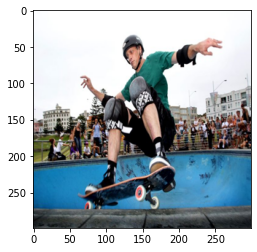

In [28]:
plt.imshow(img)

In [29]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

a man riding a skateboard on a ramp .
a skateboarder in a skate board on a ramp .
a man on a skateboard doing a trick on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard on a ramp .
a skateboarder is doing a trick on a skateboard .
a man in a skate board on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .


--2022-07-03 03:32:34--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2022-07-03 03:32:34--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104,37K  --.-KB/s    in 0,004s  

2022-07-03 03:32:35 (27,4 MB/s) - ‘data/img.jpg’ saved [106870/106870]



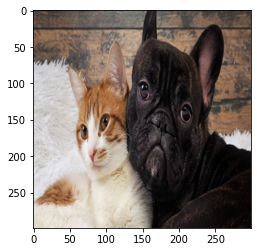

a cat is sitting on a chair with a cat .
a cat is sitting on a table with a cat .
a cat is sitting on a table with a laptop .
a cat is sitting on a table with a cat .
a cat sitting on a table with a bottle of beer .
a cat is sitting on a table with a bottle of wine .
a cat is sitting on a table with a cat .
a cat sitting on a table with a laptop .
a cat is sitting on a couch with a cat .
a cat is sitting on a couch with a laptop .


In [30]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

# Хорошие примеры


--2022-07-03 03:53:37--  https://grozny.tv/storage/images/c654fb00-a065-4bdc-ba8b-881de1aa9987.jpg
Resolving grozny.tv (grozny.tv)... 185.178.208.45
Connecting to grozny.tv (grozny.tv)|185.178.208.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75303 (74K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  73,54K  --.-KB/s    in 0,02s   

2022-07-03 03:53:38 (2,88 MB/s) - ‘data/img.jpg’ saved [75303/75303]



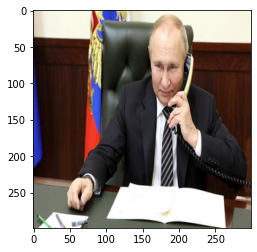

a man in a suit and tie is standing in front of a mirror .
a man wearing a suit and tie and a tie
a man wearing a suit and tie with a tie .
a man wearing a suit and tie is holding a remote control .
a man in a suit and tie with a tie .
a man sitting on a chair with a laptop on it .
a man in a suit and tie with a beard .
a man wearing a suit and tie with a tie .
a man wearing a suit and tie is holding a cell phone .
a man wearing a suit and tie with a tie .


In [31]:
!wget https://grozny.tv/storage/images/c654fb00-a065-4bdc-ba8b-881de1aa9987.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2022-07-03 03:59:45--  https://im.kommersant.ru/Issues.photo/CORP/2015/04/06/KMO_088197_194964_1_t218_112322.jpg
Resolving im.kommersant.ru (im.kommersant.ru)... 2a11:27c0::93, 178.176.128.128
Connecting to im.kommersant.ru (im.kommersant.ru)|2a11:27c0::93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100717 (98K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  98,36K  --.-KB/s    in 0,006s  

2022-07-03 03:59:45 (15,3 MB/s) - ‘data/img.jpg’ saved [100717/100717]



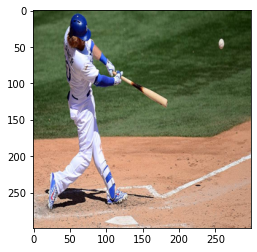

a baseball player is swinging a bat at a baseball game .
a baseball player in a uniform is swinging a bat .
a baseball player is swinging a bat at a baseball game .
a baseball player is swinging a bat at a baseball game .
a baseball player is on a baseball field .
a baseball player is swinging a bat at a baseball game .
a baseball player is swinging a bat at a baseball game .
a baseball player is swinging a bat at a ball .
a baseball player is swinging a bat at a baseball game .
a baseball player is swinging a bat at a baseball game .


In [33]:
!wget https://im.kommersant.ru/Issues.photo/CORP/2015/04/06/KMO_088197_194964_1_t218_112322.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1])) 

--2022-07-03 04:04:29--  https://phototass1.cdnvideo.ru/width/1020_b9261fa1/tass/m2/en/uploads/i/20211225/1343769.jpg
Resolving phototass1.cdnvideo.ru (phototass1.cdnvideo.ru)... 151.236.98.141
Connecting to phototass1.cdnvideo.ru (phototass1.cdnvideo.ru)|151.236.98.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg            [ <=>                ]  37,21K  --.-KB/s    in 0s      

2022-07-03 04:04:29 (206 MB/s) - ‘data/img.jpg’ saved [38107]



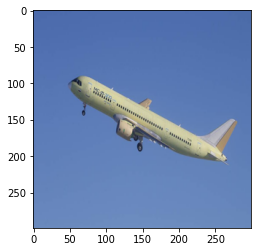

a plane flying through the air on a runway .
a large airplane flying through the air .
a large jetliner flying through the air .
a large airplane flying in the sky .
a large jetliner flying through the air .
a large jetliner flying through the air .
a plane flying through the air with a sky background
a large plane flying through the air .
a large passenger jet flying through the air .
a large jetliner flying through the air .


In [38]:
!wget https://phototass1.cdnvideo.ru/width/1020_b9261fa1/tass/m2/en/uploads/i/20211225/1343769.jpg  -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2022-07-03 04:09:49--  https://upload.wikimedia.org/wikipedia/commons/5/5d/Kamchatka_Brown_Bear_near_Dvuhyurtochnoe_on_2015-07-23.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 2620:0:862:ed1a::2:b, 91.198.174.208
Connecting to upload.wikimedia.org (upload.wikimedia.org)|2620:0:862:ed1a::2:b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5731039 (5,5M) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]   5,46M  9,64MB/s    in 0,6s    

2022-07-03 04:09:50 (9,64 MB/s) - ‘data/img.jpg’ saved [5731039/5731039]



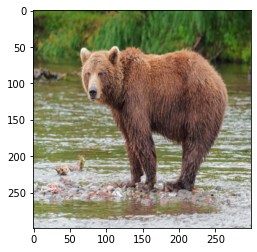

a bear walking in a field with a tree .
a bear is walking through the woods .
a bear walking across a dirt road .
a bear walking through a field of grass .
a bear is walking through the grass .
a bear walking in the grass near a tree .
a bear walking through a grassy area with a tree in the background .
a bear walking through the woods in a field .
a bear walking across a dirt road .
a bear is standing in the grass .


In [39]:
!wget https://upload.wikimedia.org/wikipedia/commons/5/5d/Kamchatka_Brown_Bear_near_Dvuhyurtochnoe_on_2015-07-23.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2022-07-03 04:14:57--  https://upload.wikimedia.org/wikipedia/commons/5/53/Weaver_bird.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 2620:0:862:ed1a::2:b, 91.198.174.208
Connecting to upload.wikimedia.org (upload.wikimedia.org)|2620:0:862:ed1a::2:b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 313992 (307K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 306,63K  1,26MB/s    in 0,2s    

2022-07-03 04:14:57 (1,26 MB/s) - ‘data/img.jpg’ saved [313992/313992]



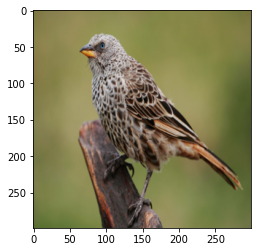

a bird sitting on a branch in a tree .
a bird perched on a branch of a tree .
a bird sitting on a branch of a tree .
a bird sitting on a branch in a tree .
a bird sitting on a branch of a tree .
a bird that is standing on a branch .
a bird sitting on a branch in a tree .
a bird sitting on a branch in a tree .
a bird sitting on a branch of a tree .
a bird sitting on a branch in a forest .


In [41]:
!wget https://upload.wikimedia.org/wikipedia/commons/5/53/Weaver_bird.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2022-07-03 04:15:47--  https://thumbs.dreamstime.com/b/bali-mynah-birds-19173506.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.233.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.233.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56928 (56K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  55,59K  --.-KB/s    in 0,03s   

2022-07-03 04:15:47 (1,80 MB/s) - ‘data/img.jpg’ saved [56928/56928]



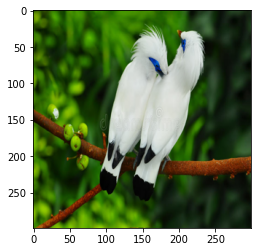

a bird is standing on a branch of a tree .
a bird perched on a branch in a forest .
a bird standing on a branch of a tree .
a bird flying through the air with a large sky .
a bird flying through the air while riding a skateboard .
a bird sitting on a branch in a park .
a bird sitting on a branch of a tree .
a bird flying through the air with a large sky .
a bird is perched on a branch in a park .
a bird is standing in the middle of a tree .


In [43]:
!wget https://thumbs.dreamstime.com/b/bali-mynah-birds-19173506.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Неудачные примеры


--2022-07-03 03:58:01--  https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Lion_%28Panthera_leo%29_male_6y.jpg/1707px-Lion_%28Panthera_leo%29_male_6y.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 2620:0:862:ed1a::2:b, 91.198.174.208
Connecting to upload.wikimedia.org (upload.wikimedia.org)|2620:0:862:ed1a::2:b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 735784 (719K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 718,54K  2,20MB/s    in 0,3s    

2022-07-03 03:58:01 (2,20 MB/s) - ‘data/img.jpg’ saved [735784/735784]



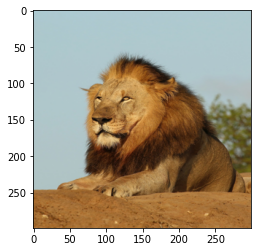

a small baby is sitting on a wooden table .
a brown and white cat sitting on a table .
a small brown and white cat sitting on a table .
a close up of a cat sitting on a table .
a small brown bear is sitting on a dirt ground .
a small bird sitting on a table with a bottle of wine .
a brown and white cat sitting on top of a wooden table .
a small brown and white cat sitting on a table .
a small baby is sitting on a chair .
a close up of a cat and a dog on a table .


In [32]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Lion_%28Panthera_leo%29_male_6y.jpg/1707px-Lion_%28Panthera_leo%29_male_6y.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))   

--2022-07-03 04:01:54--  https://naked-science.ru/wp-content/uploads/2022/02/111111111111111-min-1.jpg
Resolving naked-science.ru (naked-science.ru)... 2606:4700:3032::6815:29cc, 2606:4700:3031::ac43:c192, 172.67.193.146, ...
Connecting to naked-science.ru (naked-science.ru)|2606:4700:3032::6815:29cc|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228244 (223K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 222,89K  --.-KB/s    in 0,03s   

2022-07-03 04:01:54 (6,83 MB/s) - ‘data/img.jpg’ saved [228244/228244]



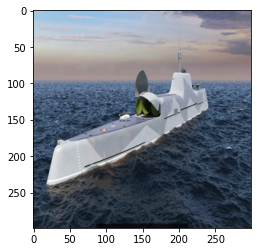

a person on a surfboard in the ocean .
a person on a surfboard in the ocean .
a person riding a surfboard on the water .
a person with a surfboard in the ocean .
a boat is on the water with a surfboard .
a man riding a surfboard on a surfboard .
a person is riding a surfboard on a wave .
a person on a surfboard in the ocean .
a boat is on a beach with a surfboard .
a person on a surfboard in the ocean .


In [35]:
!wget https://naked-science.ru/wp-content/uploads/2022/02/111111111111111-min-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1])) 

--2022-07-03 04:03:20--  https://www.psychologos.ru/uploads/articles/65bu/f6uik9d.jpg
Resolving www.psychologos.ru (www.psychologos.ru)... 87.249.57.214
Connecting to www.psychologos.ru (www.psychologos.ru)|87.249.57.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19901 (19K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  19,43K  --.-KB/s    in 0,002s  

2022-07-03 04:03:20 (9,29 MB/s) - ‘data/img.jpg’ saved [19901/19901]



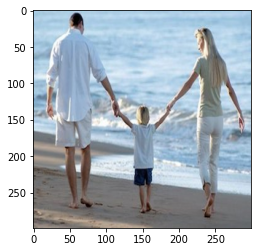

a man in a white shirt and a blue shirt and white shorts playing tennis .
a man in a white shirt and a tennis racquet .
a man in a white shirt and a white shirt and a white shirt and a white shirt and a white shirt .
a man in a white shirt and a tennis racket
a man in a white shirt and a tennis racket .
a man in a white shirt and a tennis racket .
a man in a white shirt and a white shirt and a white shirt and a white shirt .
a man and a woman playing a game of tennis .
a man in a white shirt and a white shirt and a white shirt and a white shirt .
a man in a white shirt and a blue shirt and a white shirt and a white shirt and a white shirt


In [37]:
!wget https://www.psychologos.ru/uploads/articles/65bu/f6uik9d.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2022-07-03 04:23:40--  https://cdn.w600.comps.canstockphoto.com/party-people-stock-illustrations_csp2074867.jpg
Resolving cdn.w600.comps.canstockphoto.com (cdn.w600.comps.canstockphoto.com)... 205.185.216.10, 205.185.216.42
Connecting to cdn.w600.comps.canstockphoto.com (cdn.w600.comps.canstockphoto.com)|205.185.216.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59928 (59K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>]  58,52K  --.-KB/s    in 0,05s   

2022-07-03 04:23:41 (1,15 MB/s) - ‘data/img.jpg’ saved [59928/59928]



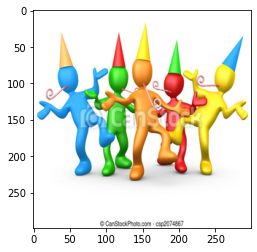

a group of people sitting around a table with a bunch of wine .
a group of people sitting around a table with a group of people .
a group of people sitting around a table with a bunch of wine .
a group of people sitting around a table with a baby .
a group of people sitting on a table with a bunch of wine .
a group of people sitting on a bench with a bunch of people .
a group of people sitting on a table with a bunch of wine .
a group of people sitting around a table with a bunch of wine .
a group of people sitting around a table with a bunch of wine glasses .
a group of people sitting on a table with a large teddy bear .


In [47]:
!wget https://cdn.w600.comps.canstockphoto.com/party-people-stock-illustrations_csp2074867.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = np.array(Image.fromarray(img).resize((299, 299)), dtype='float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)